# **Libraries/Packages Importing dan Loading Dataset**
Pada proyek Time Series ini, saya mencoba untuk mengembangkan model *univariate time series forecasting* menggunakan dataset **Monthly Sunspots** (https://machinelearningmastery.com/time-series-datasets-for-machine-learning/) dan menggunakan arsitektur **LSTM**. Agar dataset dapat diakses melalui Google Drive, terlebih dahulu saya melakukan *mounting* Google Drive saya ke Google Colab.

In [1]:
import math
import datetime
import numpy as np 
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from google.colab import drive
from sklearn.utils import shuffle
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.optimizers import SGD, RMSprop, Adam
from keras.losses import Huber
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
ds_path = '/content/drive/MyDrive/Portofolio/ML/Exercises - ML Developer Path Dicoding/Datasets'
df = pd.read_csv(ds_path + '/monthly-sunspots.csv')
df.info()
print()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Month     2820 non-null   object 
 1   Sunspots  2820 non-null   float64
dtypes: float64(1), object(1)
memory usage: 44.2+ KB



,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


In [ ]:
# Membuang kolom tanggal pada dataset, karena tidak begitu digunakan.
df = df.drop('Month', axis=1)
df.head()

,Sunspots
0,58.0
1,62.6
2,70.0
3,55.7
4,85.0


# **Exploring Dataset**
Pada bagian ini, saya mencoba untuk mengeksplorasi dataset yang akan digunakan. Eksplorasi yang dilakukan berupa **visualisasi** dataset, menguji apakah dataset time series bersifat **stasioner** atau tidak, dan memeriksa apakah terdapat data yang **NaN atau Null**.

Tujuan saya melakukan **uji stasioner** pada dataset adalah untuk meminimalisir kesalahan dalam analisis dan memastikan model yang dikembangkan dapat menghasilkan prediksi yang akurat. 

Metode **uji stasioner** yang saya gunakan adalah **Augmented Dickey-Fuller (ADF)**, dimana apabila *p-value* kecil dari 0.05 (*alpha*), dataset dapat dikatakan stasioner.

---

**Referensi**


*   https://towardsdatascience.com/time-series-forecasting-based-on-the-trend-and-seasonal-components-26b92866e548



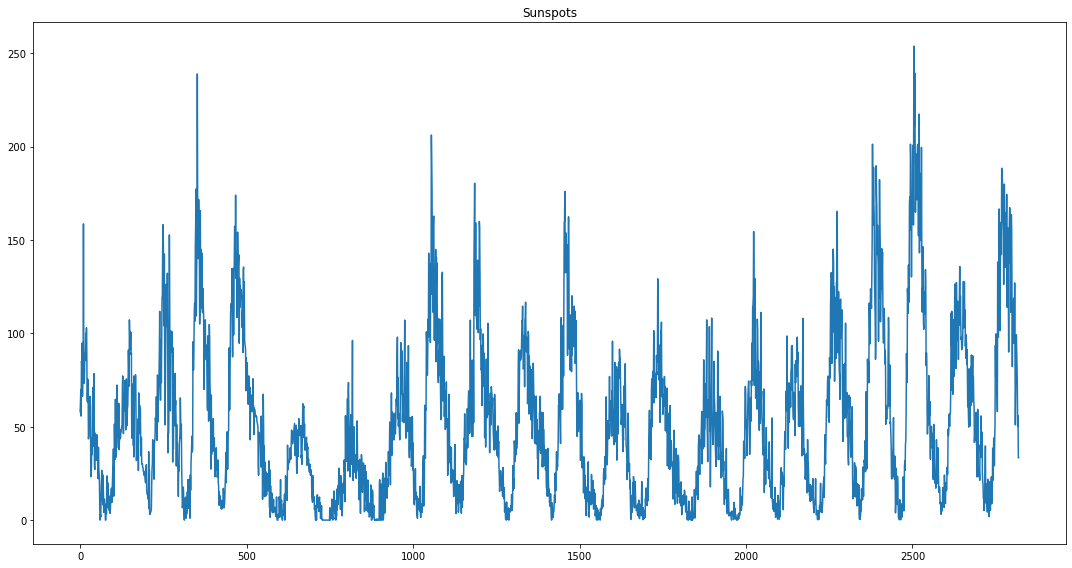

In [ ]:
# Saya membuat fungsi ini agar ke depannya lebih fleksibel dalam melakukan visualisasi dataframe, baik single-column maupun multi-columns.

def plot_subplots(dataframe):
  n_cols = min(2, len(dataframe.columns))
  n_rows = int(np.ceil(len(dataframe.columns) / n_cols))
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*8))
  if [n_cols, n_rows] != [1, 1]:
    axs = axs.flatten()
    for i in range(len(dataframe.columns)):
      axs[i].plot(dataframe.iloc[:,i])
      axs[i].set_title(dataframe.columns[i])
    for j in range(len(dataframe.columns), len(axs)):
      fig.delaxes(axs[j])
  else:
      axs.plot(dataframe.iloc[:,0])
      axs.set_title(dataframe.columns[0])
  plt.tight_layout()
  plt.show()

plot_subplots(df)

In [ ]:
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

ADF_test(df)

Results of Dickey-Fuller Test:
Test Statistic                -9.567668e+00
p-value                        2.333452e-16
Lags Used                      2.700000e+01
Number of Observations Used    2.792000e+03
Critical Value (1%)           -3.432694e+00
Critical Value (5%)           -2.862576e+00
Critical Value (10%)          -2.567321e+00
dtype: float64


In [ ]:
df.isna().sum()

Sunspots    0
dtype: int64

In [ ]:
df.isnull().sum()

Sunspots    0
dtype: int64

# **Data Preprocessing**
Pada tahap ini, *data preprocessing* yang dilakukan berupa ***scaling*** menggunakan MinMax Scaler, membuat ***data series*** untuk digunakan pada *training* dan *testing* (yang terdiri dari ***n*** (*window_size*) input dan ***1*** output), dan **pemisahan** input dan label dari dataset.

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_scaled = scaler.fit_transform(df)

In [ ]:
window_size = 7
def create_ds(data, t_steps):
    data = pd.DataFrame(data)
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i+1))], axis = 1)   
    data.dropna(axis=0, inplace=True)
    return data.values

ds = create_ds(df_scaled, window_size)

In [ ]:
num_feats = df_scaled.shape[1]
num_obs = window_size * num_feats

n_rows = ds.shape[0]
train_size = int(n_rows * 0.8)

train_data = ds[:train_size, :]
train_data = shuffle(train_data)

test_data = ds[train_size:, :]

x_train = train_data[:, :num_obs]
y_train = train_data[:, num_obs:]
x_test = test_data[:, :num_obs]
y_test = test_data[:, num_obs:]

In [ ]:
x_train = x_train.reshape(x_train.shape[0], window_size, num_feats)
x_test = x_test.reshape(x_test.shape[0], window_size, num_feats)

# **ML Modelling**
Setelah melakukan *data preprocessing*, maka tahap selanjutnya adalah pemodelan model ***machine learning***. Arsitektur utama dari model yang saya gunakan adalah ***Bidirectional LSTM***. Kemudian, saya compile model dengan menggunakan fungsi loss ***Huber***, optimizer ***Adam*** dengan ***learning rate 1e-03***, dan metrics yang digunakan adalah ***mean absolute error (MAE)***. 

Selain itu, saya juga menerapkan ***callbacks*** pada proses training model berupa ***early stopping***, dimana proses training model akan berhenti apabila nilai MAE yang dihasilkan **lebih kecil dari 5% skala data**.

In [ ]:
threshold_mae = (x_train.max() - x_train.min())*0.05
print(threshold_mae)

0.09412923561859732


In [ ]:
model = Sequential([
    Bidirectional(LSTM(256, input_shape=(window_size, num_feats), return_sequences=True)),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dense(num_feats)
])

model.compile(loss=Huber(), optimizer=Adam(learning_rate=1e-3), metrics=['mae'])

In [ ]:
class EarlyStopping(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    
    if(logs.get('mae') < threshold_mae):
      print("\nThreshold MAE dicapai. Proses Training terhenti.")
      self.model.stop_training = True

early_stopping = EarlyStopping()

In [ ]:
history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=1,  callbacks=[early_stopping], shuffle=False)

Epoch 1/100
71/71 [==============================] - 28s 117ms/step - loss: 0.0209 - mae: 0.1421
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 0.0083 - mae: 0.0924
Threshold MAE dicapai. Proses Training terhenti.
71/71 [==============================] - 10s 141ms/step - loss: 0.0083 - mae: 0.0924


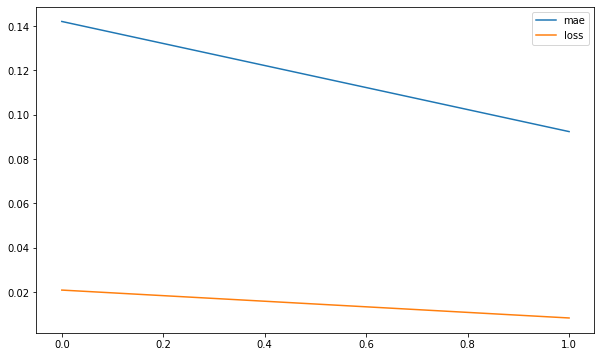

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

# **Model Testing**
Terakhir, saya melakukan **pengujian** terhadap model yang sudah dikembangkan dengan melakukan **prediksi/*forecasting* dataset testing** dan menghitung nilai rata-rata MSE dan MAE yang dihasilkan. Selain itu, saya juga melakukan pengujian menggunakan dataset training hanya untuk melihat kemampuan prediksi dari Model.

In [ ]:
def compute_metrics(true_series, forecast):
    mse = np.mean(mean_squared_error(true_series, forecast))
    mae = np.mean(mean_absolute_error(true_series, forecast))

    return mse, mae

18/18 [==============================] - 4s 37ms/step



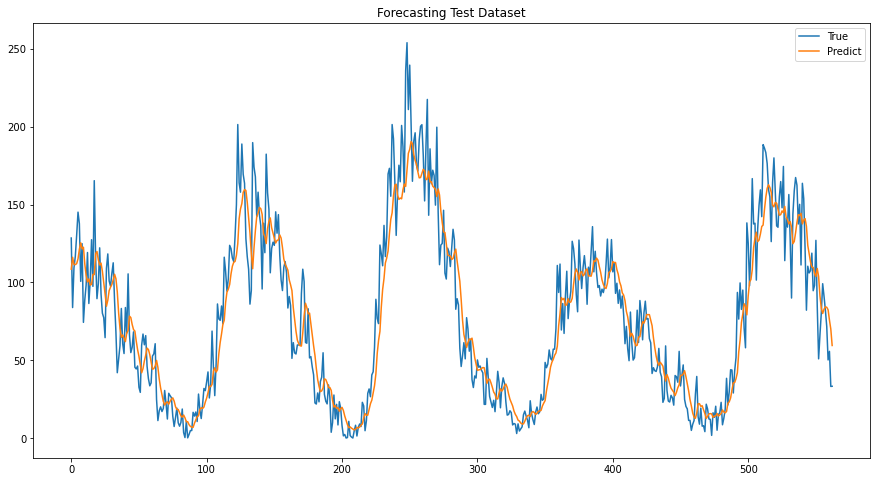

In [ ]:
y_predict = model.predict(x_test)
y_predict = scaler.inverse_transform(y_predict)

y_test_inv = scaler.inverse_transform(y_test)
y_test_inv = y_test_inv[:,0]
y_predict = y_predict[:,0]

print()

plt.figure(figsize=(15, 8))
plt.plot(y_test_inv, label='True')
plt.plot(y_predict,  label='Predict')
plt.title("Forecasting Test Dataset")
plt.legend()
plt.show()

In [ ]:
mse, mae = compute_metrics(y_test_inv, y_predict)
print(f"mse: {mse:.2f}, mae: {mae:.2f}")

mse: 426.70, mae: 15.61


71/71 [==============================] - 4s 62ms/step



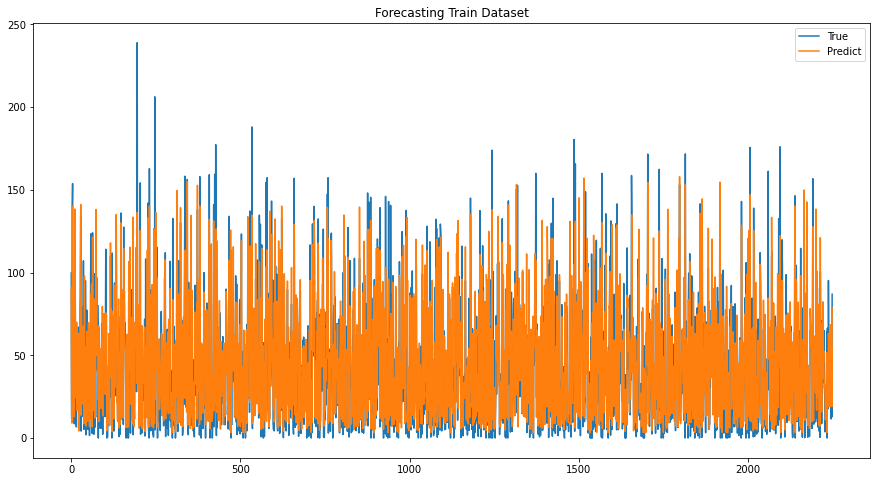

In [ ]:
y_predict_train = model.predict(x_train)
y_predict_train = scaler.inverse_transform(y_predict_train)

y_train_inv = scaler.inverse_transform(y_train)
y_train_inv = y_train_inv[:,0]
y_predict_train = y_predict_train[:,0]

print()

plt.figure(figsize=(15, 8))
plt.plot(y_train_inv, label='True')
plt.plot(y_predict_train,  label='Predict')
plt.title("Forecasting Train Dataset")
plt.legend()
plt.show()

In [ ]:
mse, mae = compute_metrics(y_train_inv, y_predict_train)
print(f"mse: {mse:.2f}, mae: {mae:.2f}")

mse: 249.22, mae: 11.33
